# Iterative results

In [238]:
import os
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix
import seaborn as sns

from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR


from fault_management_uds.config import rain_gauge_color, condition_to_meta
from fault_management_uds.synthetic.synthetic_generator import find_unterrupted_sequences
from fault_management_uds.plots import visualize_indicator_dict, get_timing
from fault_management_uds.plots import pca_plot, visualize_metric_matrix, visualize_confusion, visualize_roc_auc




In [239]:
indicator_2_data_label = json.load(open(REFERENCE_DIR / 'indicator_2_data_label.json', 'r'))


In [253]:
data_type = "train" # ["train", "val", "test"]

figures_folder = FIGURES_DIR / 'iterative' / data_type
os.makedirs(figures_folder, exist_ok=True)

# load iterations folders
save_folder = "transformer/7_anomalous"
save_folder = MODELS_DIR / save_folder
prefix = "combined_iteration="

relative_path = "1_split/anomalous"

filename = 'anomaly_prediction_results.pkl'


colormap = {
    0: 'blanchedalmond',
    1: 'slateblue',
}

hue_map = {
    'Overall': 'blanchedalmond', 
    'Spike': 'OrangeRed',
    'Noise': 'Darkblack',
    'Frozen': 'SteelBlue',
    'Offset': 'Gold',
    'Drift': 'LightSeaGreen',
}
hue_order = list(hue_map.keys())[::-1]

In [254]:
def extract_outputs(outputs, pred_sorted=False, actual_sorted=False):

    # get the model predictions

    idx_pred_0 = outputs['0']
    label_0 = np.zeros(len(idx_pred_0), dtype=int)
    idx_pred_1 = outputs['1']
    label_1 = np.ones(len(idx_pred_1), dtype=int)

    # align these predictions with the true labels
    idx_pred = np.concatenate((idx_pred_0, idx_pred_1))
    predicted = np.concatenate((label_0, label_1))


    final_method_selection = outputs['final_method_selection']

    decision_function = outputs[final_method_selection]['Decision Function']


    # get the true labels
    data_label = outputs["Data label"]
    actual = np.array([int(dl != 'Original') for dl in data_label])

    starttimes = outputs['Starttime']
    starttimes = pd.to_datetime(starttimes)

    # sort the predictions
    if pred_sorted:
        sort_indices = np.argsort(idx_pred)
        idx_pred = idx_pred[sort_indices]
        predicted = predicted[sort_indices]
        decision_function = decision_function[sort_indices]
        actual = actual[sort_indices]
        data_label = np.array(data_label)[sort_indices]
        starttimes = starttimes[sort_indices]
    
    if actual_sorted:
        sort_indices = np.argsort(actual)
        idx_pred = idx_pred[sort_indices]
        predicted = predicted[sort_indices]
        decision_function = decision_function[sort_indices]
        actual = actual[sort_indices]
        data_label = np.array(data_label)[sort_indices]
        starttimes = starttimes[sort_indices]

    else:
        # sort by starttimes
        sort_indices = np.argsort(starttimes)
        idx_pred = idx_pred[sort_indices]
        predicted = predicted[sort_indices]
        decision_function = decision_function[sort_indices]
        actual = actual[sort_indices]
        data_label = np.array(data_label)[sort_indices]
        starttimes = starttimes[sort_indices]




    return predicted, decision_function, actual, data_label, starttimes
#idx_pred, Predicted, decision_function, true, data_label

In [255]:
runs = os.listdir(save_folder)
runs = [run for run in runs if run.startswith(prefix)]
n_iterations = len(runs)
print(f"Highest iteration: {n_iterations}")
print(runs)
print('')
combined_results = {}

iterations = []
iter_names = []
for run in runs:
    print(f"Run: {run}")
    iteration = run.split("=")[1]
    iter_name = f"Iteration {iteration.lower().replace(' ', '_')}"
    combined_results[iter_name] = {}

    # load the outputs file
    outputs_file = save_folder / run / data_type / filename
    thresholds_file = save_folder / run / 'optimal_thresholds.pkl'

    # check if the file exists
    if not outputs_file.exists():
        print(f"File does not exist: {outputs_file}")
        continue

    if not thresholds_file.exists():
        print(f"File does not exist: {thresholds_file}")
        continue

    #/ relative_path / data_type / filename
    outputs = pd.read_pickle(outputs_file)
    thresholds = pd.read_pickle(thresholds_file)
    #print(f"Thresholds: {thresholds}")

    predicted, decision_function, actual, data_label, starttimes = extract_outputs(outputs)
    
    # combined results
    combined_results[iter_name] = {
        #"Predicted": predicted,
        "Predicted": (decision_function > thresholds["Multi-Feature"]).astype(int),
        'Decision Function': decision_function,
        "Actual": actual,
        "data_label": data_label,
        "Optimal Threshold": thresholds["Multi-Feature"],
        "Starttimes": starttimes,
    }


    iterations.append(iteration)
    iter_names.append(iter_name)

# sort
iterations = sorted(iterations)
iter_names = sorted(iter_names)


Highest iteration: 3
['combined_iteration=1', 'combined_iteration=0', 'combined_iteration=2']

Run: combined_iteration=1
Run: combined_iteration=0
Run: combined_iteration=2


In [256]:
# ensure that the keys in the dict go frm iter 0 to iter n
combined_results = {k: combined_results[k] for k in iter_names}

In [257]:
# print the optimal thresholds
for iter_name in iter_names:
    print(f"Iteration {iter_name}")
    print(f"Optimal Thresholds: {combined_results[iter_name]['Optimal Threshold']}")
    print('')

Iteration Iteration 0
Optimal Thresholds: -0.061964638010240214

Iteration Iteration 1
Optimal Thresholds: -0.058773846738090774

Iteration Iteration 2
Optimal Thresholds: -0.05041607377673757



In [258]:
from itertools import product


def generate_strings(n):
    result = ["0"]  # Start with "0"
    
    for length in range(1, n + 1):
        for bits in product("01", repeat=length):
            result.append("0." + ".".join(bits))  # Construct strings with "0." prefix
            
    return result

# Example usage:
run_prefixes = generate_strings(n_iterations - 1)
print(run_prefixes)


['0', '0.0', '0.1', '0.0.0', '0.0.1', '0.1.0', '0.1.1']


In [259]:
# get results for each iteration

run_folders = os.listdir(save_folder)
prefix = "iteration="
runs = []
for run_prefixe in run_prefixes:
    runs.extend([run for run in run_folders if run.startswith(f"{prefix}{run_prefixe}_")])
#runs = [run for run in runs if run.startswith(prefix)]
print(f"Total: {len(runs)}")
# take ceil of log2 of the number of runs to get the highest iteration
n_iterations = int(np.ceil(np.log2(len(runs))))
print(f"Highest iteration: {n_iterations}")
print(runs)
results = {}
for run in runs:
    # get the iteration number
    iteration_identifier = run.split("=")[-1].split("_")[0]
    n_iteration = len(iteration_identifier.split("."))
    # if n_iteration > 2:
    #     # go to next iteration
    #     continue
    print(f"Iteration identifier: {iteration_identifier}")
    print(f"Number of iteration: {n_iteration}")

    # load the outputs file
    outputs_file = save_folder / run / relative_path / data_type / filename
    outputs = pd.read_pickle(outputs_file)
    Predicted, decision_function, actual, data_label, starttimes = extract_outputs(outputs, pred_sorted=True)
    results[iteration_identifier] = {
        "Predicted": Predicted,
        'Decision Function': decision_function,
        "Actual": actual,
        "data_label": data_label,
        "Starttimes": starttimes,
    }
    print('')
    


Total: 7
Highest iteration: 3
['iteration=0_250206_0903', 'iteration=0.0_250226_1007', 'iteration=0.1_250226_1056', 'iteration=0.0.0_250228_0944', 'iteration=0.0.1_250228_0939', 'iteration=0.1.0_250228_1214', 'iteration=0.1.1_250228_0939']
Iteration identifier: 0
Number of iteration: 1

Iteration identifier: 0.0
Number of iteration: 2

Iteration identifier: 0.1
Number of iteration: 2

Iteration identifier: 0.0.0
Number of iteration: 3

Iteration identifier: 0.0.1
Number of iteration: 3

Iteration identifier: 0.1.0
Number of iteration: 3

Iteration identifier: 0.1.1
Number of iteration: 3



In [260]:
# create a combined results where it is not iterations, concatenate the results
ano_pred_timeline = {}
iter_to_keys = {}
iter_keys = list(results.keys())
for iteration in iterations:
    iter_name = f"Iteration {iteration.lower().replace(' ', '_')}"
    print(f"Iteration: {iteration.lower().replace(' ', '_')}")
    # find relevant keys
    relevant_keys = [key for key in iter_keys if len(key.split(".")) == int(iteration)+1]
    # sort keys so that 0 then 1
    relevant_keys = sorted(relevant_keys)
    iter_to_keys[iteration] = relevant_keys
    print(f"Relevant keys: {relevant_keys}")
    # concatenate the results
    #combined_results[iteration] = {}
    ano_pred_timeline[iter_name] = {
        'colormap': colormap,
    }
    for key in relevant_keys:
        # create timeline data: sort Predicted
        ano_pred_timeline[iter_name]['indicator'] = np.concatenate((ano_pred_timeline[iter_name].get('indicator', []), sorted(results[key]["Predicted"]))) # if you have array (1,0,1), then sorted will give (0,1,1)


Iteration: 0
Relevant keys: ['0']
Iteration: 1
Relevant keys: ['0.0', '0.1']
Iteration: 2
Relevant keys: ['0.0.0', '0.0.1', '0.1.0', '0.1.1']


## The data split sizes

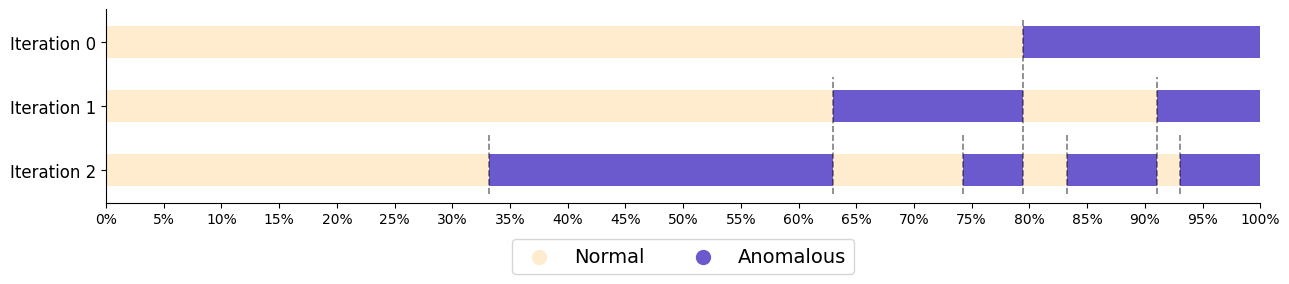

In [261]:
# indicator plot
fig, ax = plt.subplots(figsize=(13, 3)) 

# predicted anomalies in each subset
ax = visualize_indicator_dict(ax, ano_pred_timeline, start=None, end=None, adjust='half-point', ylabel='')
ax.set_xlim(0, len(ano_pred_timeline['Iteration 0']['indicator']))
total_length = len(ano_pred_timeline['Iteration 0']['indicator'])
xticks = np.linspace(0, total_length - 1, num=21, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{round(x / total_length * 100)}%" for x in xticks])
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)#; ax.spines['left'].set_visible(False)
# increase y-ticks font size
ax.tick_params(axis='y', labelsize=12)


ymin, ymax = ax.get_ylim()
diff_step = abs(ymax - ymin) / len(iterations)
ignore = [-100] # dummy value to not be empty
for iteration in iterations:    
    # find the indices where we go from 0 to 1 or 1 to 0
    indices = np.where(np.diff(ano_pred_timeline['Iteration ' + iteration]['indicator']) != 0)[0]
    # show decision boundaries
    i=0
    for idx in indices:
        if min([abs(idx - x) for x in ignore]) < 10:
            continue
        _ymin = ymin
        _ymax = ymax + int(iteration) * diff_step
        ax.vlines(idx, 
                  _ymin, _ymax, 
                  color='black', linestyle='--', alpha=0.5, linewidth=1.2)
        ignore.append(idx)
        i += 1
        
# add legend based on colormap
for i, (key, value) in enumerate(colormap.items()):
    ax.scatter([], [], color=value, label=str(key).replace('0', 'Normal').replace('1', 'Anomalous'), s=100)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), ncol=len(colormap), fontsize=14)

plt.tight_layout()
plt.savefig(figures_folder / f'anomaly_timeline_{data_type}.png', dpi=150)
plt.show()

In [262]:
# get results for each iteration

run_folders = os.listdir(save_folder)
prefix = "iteration="
runs = []
for run_prefixe in run_prefixes:
    runs.extend([run for run in run_folders if run.startswith(f"{prefix}{run_prefixe}_")])
#runs = [run for run in runs if run.startswith(prefix)]
print(f"Total: {len(runs)}")
# take ceil of log2 of the number of runs to get the highest iteration
n_iterations = int(np.ceil(np.log2(len(runs))))
print(f"Highest iteration: {n_iterations}")
print(runs)
results = {}
for run in runs:
    # get the iteration number
    iteration_identifier = run.split("=")[-1].split("_")[0]
    n_iteration = len(iteration_identifier.split("."))
    # if n_iteration > 2:
    #     # go to next iteration
    #     continue
    print(f"Iteration identifier: {iteration_identifier}")
    print(f"Number of iteration: {n_iteration}")

    # load the outputs file
    outputs_file = save_folder / run / relative_path / data_type / filename
    outputs = pd.read_pickle(outputs_file)
    Predicted, decision_function, actual, data_label, starttimes = extract_outputs(outputs, actual_sorted=True)
    results[iteration_identifier] = {
        "Predicted": Predicted,
        'Decision Function': decision_function,
        "Actual": actual,
        "data_label": data_label,
        "Starttimes": starttimes,
    }
    print('')
    


Total: 7
Highest iteration: 3
['iteration=0_250206_0903', 'iteration=0.0_250226_1007', 'iteration=0.1_250226_1056', 'iteration=0.0.0_250228_0944', 'iteration=0.0.1_250228_0939', 'iteration=0.1.0_250228_1214', 'iteration=0.1.1_250228_0939']
Iteration identifier: 0
Number of iteration: 1

Iteration identifier: 0.0
Number of iteration: 2

Iteration identifier: 0.1
Number of iteration: 2

Iteration identifier: 0.0.0
Number of iteration: 3

Iteration identifier: 0.0.1
Number of iteration: 3

Iteration identifier: 0.1.0
Number of iteration: 3

Iteration identifier: 0.1.1
Number of iteration: 3



In [263]:
# create a combined results where it is not iterations, concatenate the results

actual_cmap = {
    0: 'forestgreen',
    1: 'firebrick',
}

ano_pred_timeline = {}
iter_to_keys = {}
iter_keys = list(results.keys())
for i, iteration in enumerate(iterations):
    iter_name = f"Iteration {iteration.lower().replace(' ', '_')}"
    print(f"Iteration: {iteration.lower().replace(' ', '_')}")
    # find relevant keys
    relevant_keys = [key for key in iter_keys if len(key.split(".")) == int(iteration)+1]
    # sort keys so that 0 then 1
    relevant_keys = sorted(relevant_keys)
    iter_to_keys[iteration] = relevant_keys
    print(f"Relevant keys: {relevant_keys}")
    # concatenate the results
    #combined_results[iteration] = {}
    #actual_name = f"Actual in iter={iteration.lower().replace(' ', '_')}"
    actual_name = f"Actual_{iteration.lower().replace(' ', '_')}"

    ano_pred_timeline[actual_name] = {
        'colormap': actual_cmap,
    }
    ano_pred_timeline[iter_name] = {
        'colormap': colormap,
    }
    for key in relevant_keys:
        # create timeline data: sort Predicted
        ano_pred_timeline[actual_name]['indicator'] = np.concatenate((ano_pred_timeline[actual_name].get('indicator', []), sorted((results[key]["data_label"] != 'Original').astype(int)))) # if you have array (1,0,1), then sorted will give (0,1,1)
        ano_pred_timeline[iter_name]['indicator'] = np.concatenate((ano_pred_timeline[iter_name].get('indicator', []), sorted(results[key]["Predicted"]))) # if you have array (1,0,1), then sorted will give (0,1,1)


    if i == len(iterations) - 1:
        actual_name = f"Actual_{int(iteration.lower().replace(' ', '_'))+1}"
        ano_pred_timeline[actual_name] = {
            'colormap': actual_cmap,
        }
        # get the last actual
        for key in relevant_keys:
            actual = (results[key]["data_label"] != 'Original').astype(int)
            predicted = results[key]["Predicted"]
            actual_pred_0 = actual[predicted == 0]
            ano_pred_timeline[actual_name]['indicator'] = np.concatenate((ano_pred_timeline[actual_name].get('indicator', []), sorted(actual_pred_0)))
            actual_pred_1 = actual[predicted == 1]
            ano_pred_timeline[actual_name]['indicator'] = np.concatenate((ano_pred_timeline[actual_name].get('indicator', []), sorted(actual_pred_1)))



Iteration: 0
Relevant keys: ['0']
Iteration: 1
Relevant keys: ['0.0', '0.1']
Iteration: 2
Relevant keys: ['0.0.0', '0.0.1', '0.1.0', '0.1.1']


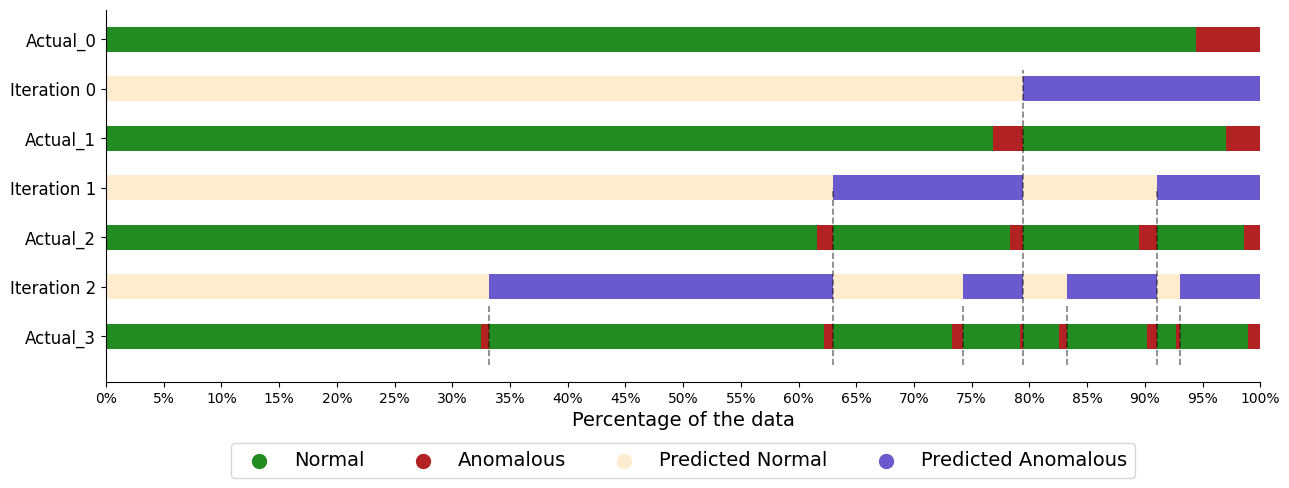

In [264]:
# indicator plot
fig, ax = plt.subplots(figsize=(13, 5)) 

# predicted anomalies in each subset
ax = visualize_indicator_dict(ax, ano_pred_timeline, start=None, end=None, adjust='half-point', ylabel='')
ax.set_xlim(0, len(ano_pred_timeline['Iteration 0']['indicator']))
total_length = len(ano_pred_timeline['Iteration 0']['indicator'])
xticks = np.linspace(0, total_length - 1, num=21, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{round(x / total_length * 100)}%" for x in xticks])
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)#; ax.spines['left'].set_visible(False)
# increase y-ticks font size
ax.tick_params(axis='y', labelsize=12)


ymin, ymax = ax.get_ylim()
diff_step = abs(ymax - ymin) / len(iterations)
ignore = [-100] # dummy value to not be empty
for iteration in iterations:    
    # find the indices where we go from 0 to 1 or 1 to 0
    indices = np.where(np.diff(ano_pred_timeline['Iteration ' + iteration]['indicator']) != 0)[0]
    # show decision boundaries
    i=0
    for idx in indices:
        if min([abs(idx - x) for x in ignore]) < 10:
            continue
        _ymin = ymin
        _ymax = ymax + (int(iteration)+1/2) * diff_step
        ax.vlines(idx, 
                  _ymin, _ymax, # this is like a line from (idx, ymin) to (idx, ymax)
                  color='black', linestyle='--', alpha=0.5, linewidth=1.2)
        ignore.append(idx)
        i += 1
        
# add legend based on colormap
for i, (key, value) in enumerate(actual_cmap.items()):
    ax.scatter([], [], color=value, label=str(key).replace('0', 'Normal').replace('1', 'Anomalous'), s=100)
for i, (key, value) in enumerate(colormap.items()):
    ax.scatter([], [], color=value, label=str(key).replace('0', 'Predicted Normal').replace('1', 'Predicted Anomalous'), s=100)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), ncol=4, fontsize=14)
# add x label
ax.set_xlabel("Percentage of the data", fontsize=14)
plt.tight_layout()
plt.savefig(figures_folder / f'anomaly_timeline_{data_type}_v2.png', dpi=150)
plt.show()

## Error matrices

In [201]:
len(actual), len(Predicted), len(data_label)

(335239, 335239, 335239)

In [202]:
combined_results.keys()

dict_keys(['Iteration 0', 'Iteration 1', 'Iteration 2'])

Iteration: iteration_0


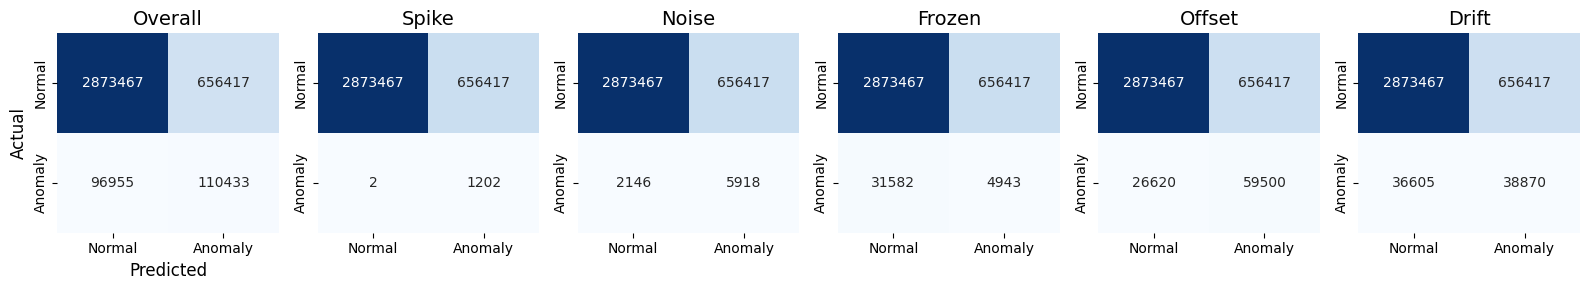

Iteration: iteration_1


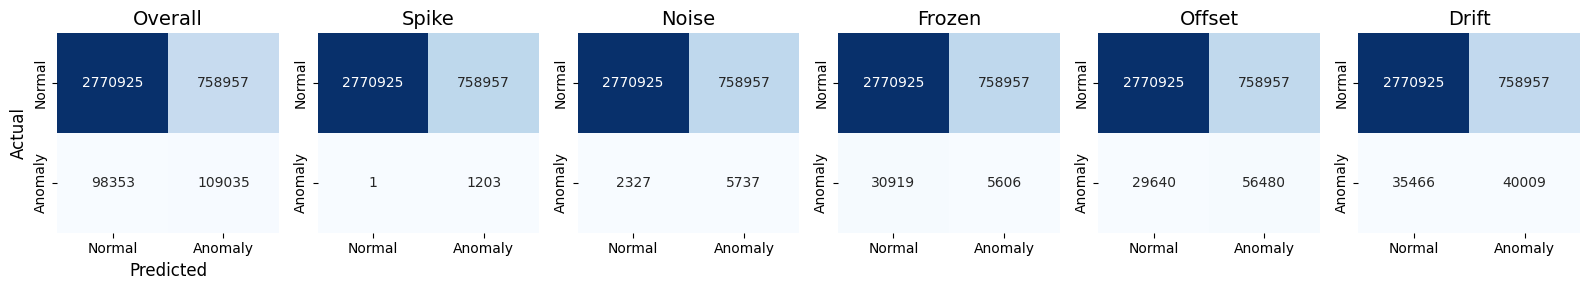

Iteration: iteration_2


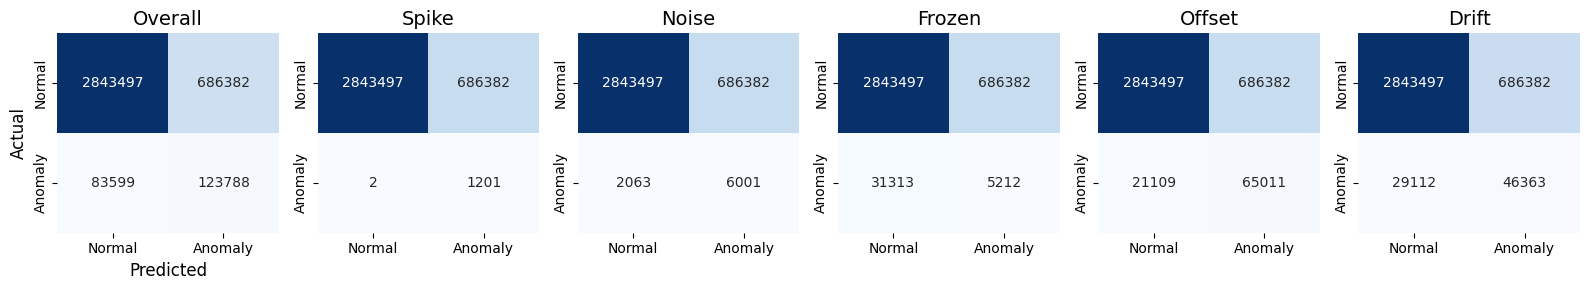

In [203]:
n_rows = len(combined_results)
n_cols = len(hue_order)
# create subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

for i, iteration in enumerate(sorted(list(combined_results.keys()))):
    fig, axes = plt.subplots(1, n_cols, figsize=(16, 3))
    actual = combined_results[iteration]["Actual"]
    data_label = combined_results[iteration]['data_label']
    pred_label = combined_results[iteration]['Predicted']  
    for j, label in enumerate(hue_order[::-1]):
        if label == 'Overall':
            # set mask to all the data
            mask = np.ones(len(actual), dtype=bool)
        else:
             # set mask to the label and original
             mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')

        conf_matrix = confusion_matrix(actual[mask], pred_label[mask])
        axes[j] = visualize_confusion(axes[j], j, label, conf_matrix, 'd', 'Blues')

    # set title for the entire row
    #fig.suptitle(iteration, fontsize=15, x=0.5, y=1.05)  # Adjust x and y for centering
    print(f"Iteration: {iteration.lower().replace(' ', '_')}")
    plt.tight_layout()
    plt.savefig(figures_folder / f"confusion_matrix_{iteration.lower().replace(' ', '_')}_{data_type}.png", dpi=150)
    plt.show()


## The AUC scores

In [204]:
# n_cols = len(combined_results)
# # create subplots
# fig, axes = plt.subplots(1, len(combined_results), figsize=(14, 4))

# for i, iteration in enumerate(sorted(list(combined_results.keys()))):
#     actual = combined_results[iteration]["Actual"]
#     data_label = combined_results[iteration]['data_label']
#     decision_function = combined_results[iteration]['Decision Function'] 
    
#     # ROC curve
#     fpr, tpr, _ = roc_curve(actual, decision_function)
#     roc_auc = auc(fpr, tpr)
#     # def visualize_roc_auc(ax, i, key, fpr, tpr, roc_auc):
#     axes[i] = visualize_roc_auc(axes[i], i, iteration, fpr, tpr, roc_auc)
#     # set title for the entire row
#     #fig.suptitle(iteration, fontsize=15, x=0.5, y=1.05)  # Adjust x and y for centering
# plt.tight_layout()
# plt.savefig(figures_folder / f'roc_auc_Overall.png', dpi=150)
# plt.show()
# plt.close()



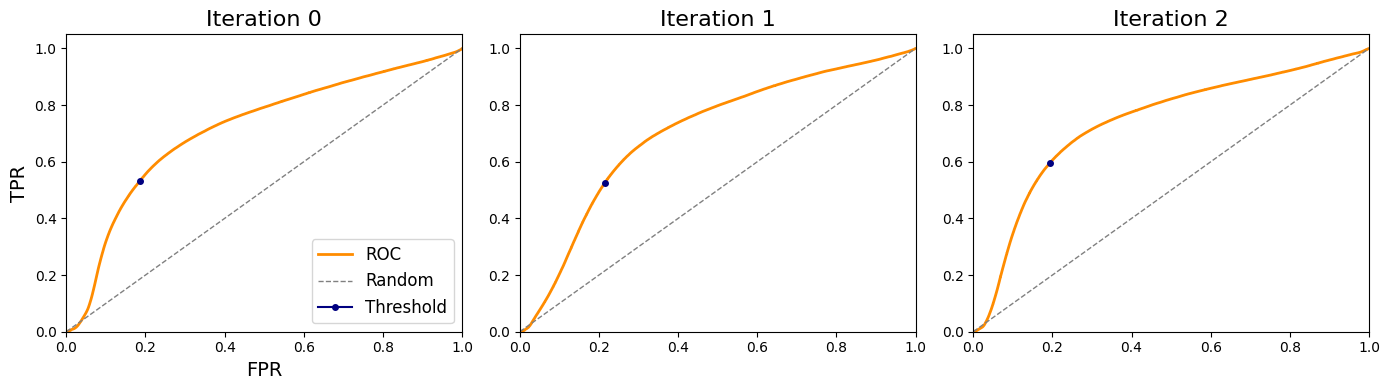

In [205]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  # Adjust height for 2 rows
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

auc_scores = {}
#for i, key in enumerate(methods):
for i, key in enumerate(sorted(list(combined_results.keys()))):

    # ROC curve
    fpr, tpr, thresholds = roc_curve(combined_results[key]['Actual'], combined_results[key]['Decision Function'])
    roc_auc = auc(fpr, tpr)
    auc_scores[key] = {'Overall': roc_auc}
    # Find the index based on the optimal threshold
    optimal_threshold = combined_results[key]['Optimal Threshold']
    optimal_index = np.argmin(np.abs(thresholds - optimal_threshold)) # Find the index of the optimal threshold based on smallest difference
    optimal_fpr = fpr[optimal_index]
    optimal_tpr = tpr[optimal_index]
    axes[i] = visualize_roc_auc(axes[i], i, key, fpr, tpr, roc_auc, optimal_fpr, optimal_tpr)
    # remove legend
    if i != 0:
        axes[i].legend().remove()
plt.tight_layout()
plt.savefig(figures_folder / 'roc_auc_overall.png', dpi=200)
plt.show()
plt.close()


Iteration: iteration_0


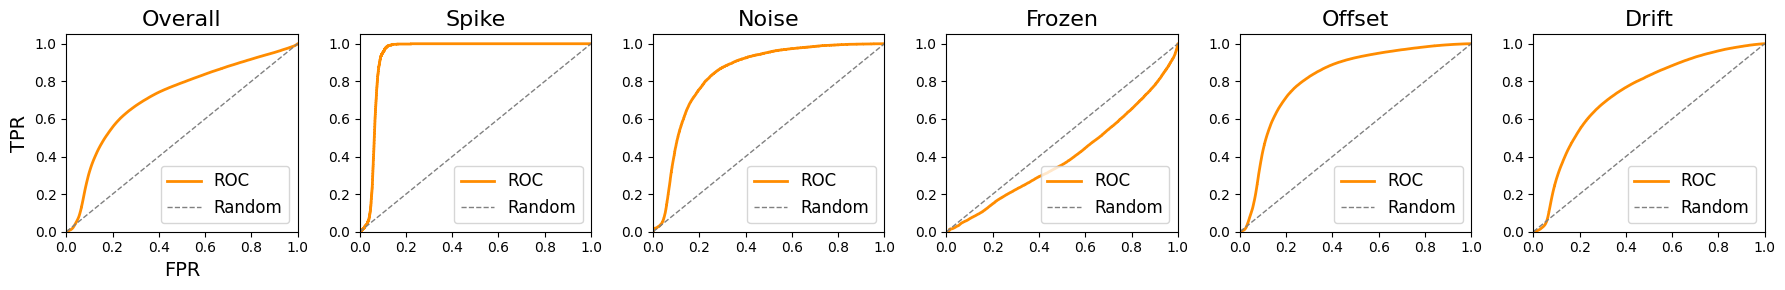

Iteration: iteration_1


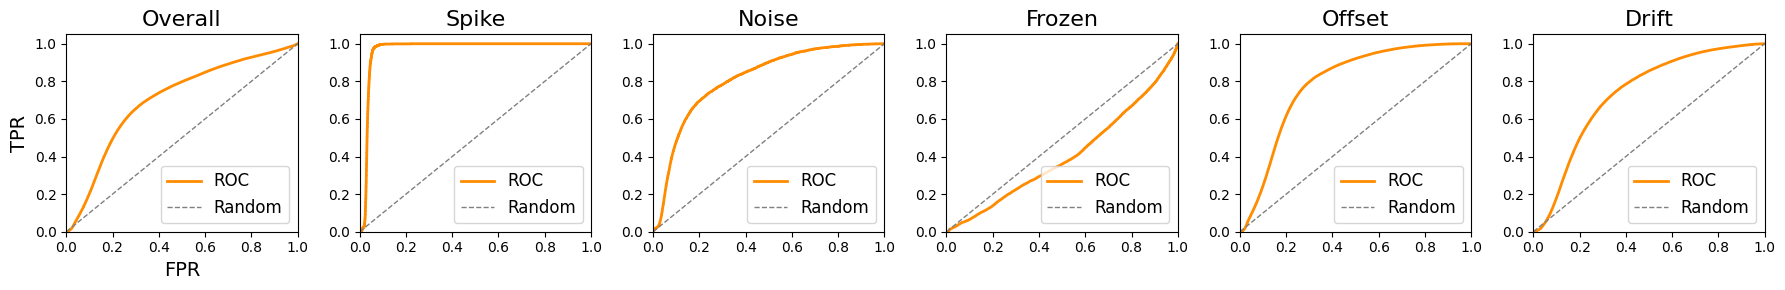

Iteration: iteration_2


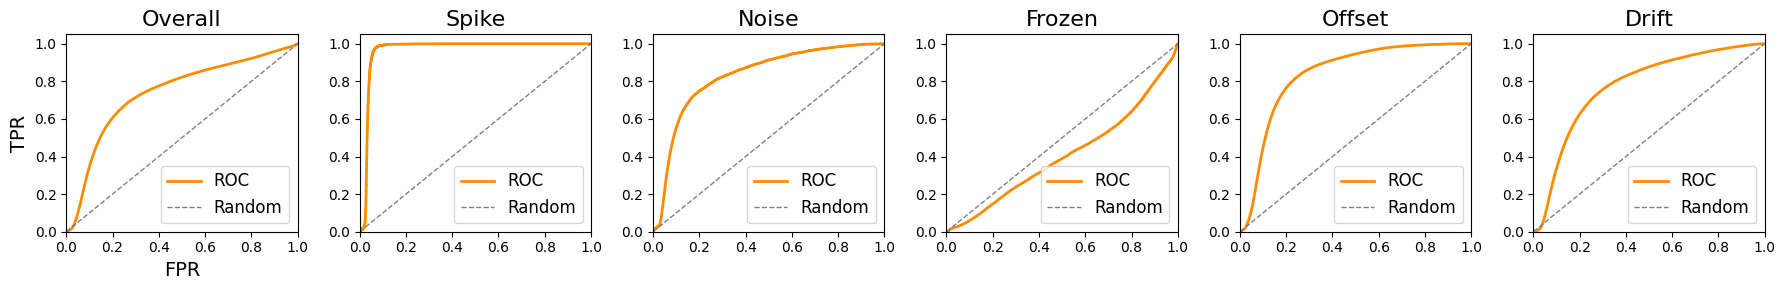

In [206]:
n_rows = len(combined_results)
n_cols = len(hue_order)
# create subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

auc_dict = {}
for i, iteration in enumerate(sorted(list(combined_results.keys()))):
    auc_dict[iteration] = {}
    fig, axes = plt.subplots(1, n_cols, figsize=(18, 3))
    actual = combined_results[iteration]["Actual"]
    data_label = combined_results[iteration]['data_label']
    decision_function = combined_results[iteration]['Decision Function'] 
    for j, label in enumerate(hue_order[::-1]):
        if label == 'Overall':
            # set mask to all the data
            mask = np.ones(len(actual), dtype=bool)
        else:
             # set mask to the label and original
             mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')

        #print(f'Anomaly: {label}')
        # ROC curve
        fpr, tpr, _ = roc_curve(actual[mask], decision_function[mask])
        roc_auc = auc(fpr, tpr)
        auc_dict[iteration][label] = roc_auc
        # def visualize_roc_auc(ax, i, key, fpr, tpr, roc_auc):
        axes[j] = visualize_roc_auc(axes[j], j, label, fpr, tpr, roc_auc)
    # set title for the entire row
    #fig.suptitle(iteration, fontsize=15, x=0.5, y=1.05)  # Adjust x and y for centering
    print(f"Iteration: {iteration.lower().replace(' ', '_')}")
    plt.tight_layout()
    plt.savefig(figures_folder / f"roc_auc_{iteration.lower().replace(' ', '_')}_{data_type}.png", dpi=150)
    plt.show()

auc_df = pd.DataFrame(auc_dict)

## Matrix of AUC

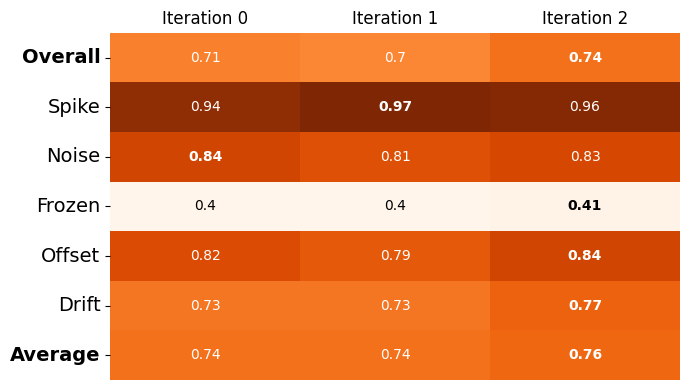

In [207]:
# row ordering
row_order = ['Average'] + hue_order[:-1] + ['Overall']

# AUC
metric_df = pd.DataFrame(auc_dict)
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[hue_order[:-1]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('AUC', metric_df, 'Oranges', 2, top_n_bold=1, bottom_n_bold=1, suffix=None, figsize=(7, 4), save_folder=figures_folder)
visualize_metric_matrix('AUC', metric_df, 'Oranges', 2, top_n_bold=1, bottom_n_bold=1, suffix=None, figsize=(7, 4), save_folder=None)



In [208]:
# row_order = hue_order[1:] + ['Average', 'Overall']
# # Calculate the average AUC as well
# auc_df.loc['Average'] = auc_df.loc[hue_order[1:]].mean()
# # reorder the rows
# auc_df = auc_df.loc[row_order]
# auc_df = auc_df.T
# # inverse the order of the rows
# auc_df = auc_df.iloc[::-1]
# # inverse order of the columns
# auc_df = auc_df.iloc[:, ::-1]

# visualize_metric_matrix(
#     'roc_auc',
#     auc_df, 
#     'Oranges', 2, suffix=None,
#     high_best=True,
#     figsize=(9, 2), 
#     save_folder=None,#figures_folder,
#     top_n_bold=0,
#     annotate_row_wise=False,
#     ysize=14

# )

# Decision function distribution

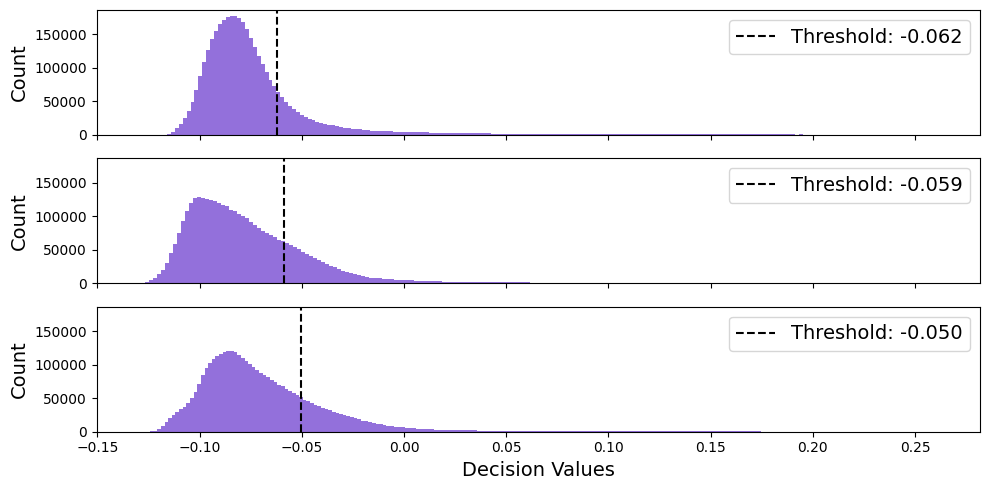

In [209]:


fig, axes = plt.subplots(len(list(combined_results.keys())), 1, figsize=(10, 5), sharex=True, sharey=True)

# Normal Data, Predicted Synthetic, Not Predicted Synthetic
#for i, key in enumerate(methods):
for i, iteration in enumerate(sorted(list(combined_results.keys()))):
    actual = combined_results[iteration]['Actual']

    normal_data = combined_results[iteration]['Decision Function']
    axes[i].hist(normal_data, bins=200, color='mediumpurple',
                alpha=1)
    threshold = combined_results[iteration]['Optimal Threshold']
    axes[i].axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.3f}')
    axes[i].set_ylabel('Count', fontsize=14)
    #if i == 0:
    axes[i].legend(loc='upper right', fontsize=14)

axes[-1].set_xlabel('Decision Values', fontsize=14)

    
# axes[0, 0].set_ylabel('Normal Data', fontsize=12, rotation=0, labelpad=0, ha='right')
# axes[1, 0].set_ylabel('True Positive', fontsize=12, rotation=0, labelpad=0, ha='right')
# axes[2, 0].set_ylabel('False Negative', fontsize=12, rotation=0, labelpad=0, ha='right')
# axes[0, 0].yaxis.set_major_formatter(formatter)
# axes[1, 0].yaxis.set_major_formatter(formatter)
# axes[2, 0].yaxis.set_major_formatter(formatter)
# axes[2, 0].set_xlabel('Decision Values', fontsize=12)
# fig.align_ylabels()  # ensures all y-labels are properly aligned



plt.tight_layout()
plt.savefig(figures_folder / 'decision_function_distributions.png')
plt.show()
plt.close()


# Intervals analysis

In [210]:

# # Intervals and coverage
intervals_count = {}
intervals_sizes = {}
intervals_decisions = {}


#for i, key in enumerate(methods):
for i, iteration in enumerate(sorted(list(combined_results.keys()))):


    # Get total intervals per method
    # Get the start and end of each anomaly
    indices_of_ones = [index for index, value in enumerate(combined_results[iteration]['Predicted']) if value == 1]
    _, predicted_start_end = find_unterrupted_sequences(indices_of_ones, 0)
    total_predicted_intervals = len(predicted_start_end)
    predicted_intervals_sizes = [end - start + 1 for start, end in predicted_start_end] 
    predicted_decisions = [np.mean(combined_results[iteration]['Decision Function'][start:end+1]) for start, end in predicted_start_end]

    
    # Get total intervals with some coverage
    # Filter so that only keep start_and if any value in predicted_start_end is also 1 or more in actual
    predicted_and_actual_start_end = [start_end for start_end in predicted_start_end if np.sum(combined_results[iteration]['Actual'][start_end[0]:start_end[1]+1]) > 0]
    total_intervals_with_coverage = len(predicted_and_actual_start_end)
    coverage_intervals_sizes = [end - start + 1 for start, end in predicted_and_actual_start_end]
    coverage_decisions = [np.mean(combined_results[iteration]['Decision Function'][start:end+1]) for start, end in predicted_and_actual_start_end]


    # Get total intervals without any coverage
    total_intervals_without_coverage = total_predicted_intervals - total_intervals_with_coverage
    no_coverage_intervals_sizes = [end - start + 1 for start, end in predicted_start_end if (start, end) not in predicted_and_actual_start_end]
    no_coverage_decisions = [np.mean(combined_results[iteration]['Decision Function'][start:end+1]) for start, end in predicted_start_end if (start, end) not in predicted_and_actual_start_end]

    # Store the results
    intervals_count[iteration] = {
        'Total Predicted Intervals': total_predicted_intervals,
        'Intervals without true-positives': total_intervals_without_coverage,
        'Intervals with true-positives': total_intervals_with_coverage,

    }
    intervals_sizes[iteration] = {
        'Predicted Intervals Sizes': [end - start + 1 for start, end in predicted_start_end],
        'Intervals Sizes without TP': [end - start + 1 for start, end in predicted_start_end if (start, end) not in predicted_and_actual_start_end],
        'Intervals Sizes with TP': [end - start + 1 for start, end in predicted_and_actual_start_end],
    }

    intervals_decisions[iteration] = {
        'Predicted Decisions': predicted_decisions,
        'No Coverage Decisions': no_coverage_decisions,
        'Coverage Decisions': coverage_decisions,
    }



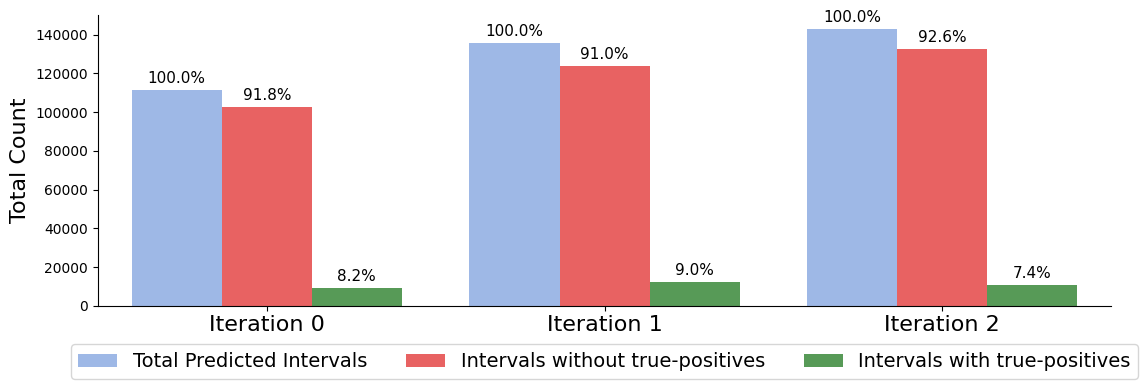

In [211]:

# Convert data to a DataFrame for easy visualization
df = pd.DataFrame.from_dict(intervals_count, orient="index").reset_index()
df = df.melt(id_vars="index", var_name="Category", value_name="Count")
df.rename(columns={"index": "Iteration"}, inplace=True)

custom_palette = ["cornflowerblue", "red", "green"]

# Plot
plt.figure(figsize=(12, 4))
ax = sns.barplot(data=df, x="Iteration", y="Count", hue="Category", palette=custom_palette, alpha=0.7)

# Add count labels on top of bars
# Assume the first container is the baseline (100%)
baseline_value = ax.containers[0].datavalues  # First container value

for container in ax.containers:
    values = np.array(container.datavalues)
    # Replace NaN values with 0
    values = np.nan_to_num(values)
    
    # Check for division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        labels = values / baseline_value
    
    # Replace NaN or infinite values with 0
    labels = np.nan_to_num(labels)
    
    # Format as percentage
    labels = [f"{v:.1%}" if v > 0 else "" for v in labels]
    
    # Add bar labels only where values are non-zero
    ax.bar_label(container, labels=labels, label_type="edge", fontsize=11, padding=3)

# increase font size for x-axis
plt.xticks(fontsize=16)


# Labels and title
plt.ylabel("Total Count", fontsize=16)
plt.xlabel(" ", fontsize=12)

plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=14)
#plt.grid(axis="x", linestyle="--", alpha=0.6)

# remove spines on top and right
sns.despine()

plt.tight_layout()
plt.savefig(figures_folder / 'intervals_count_pct.png')
plt.show()
plt.close()


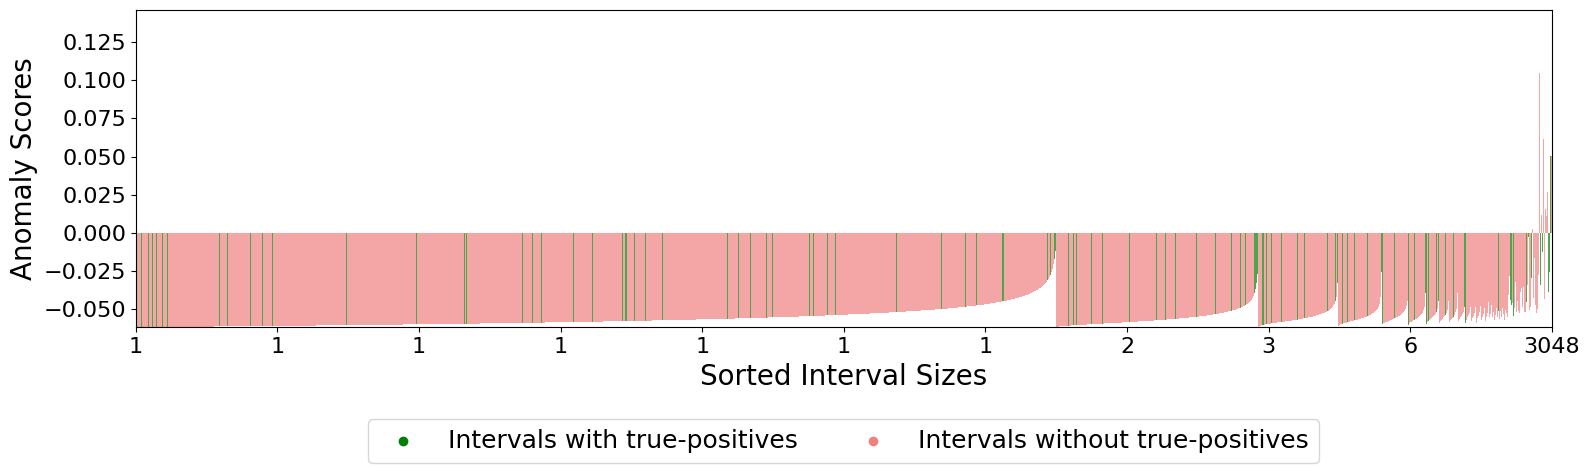

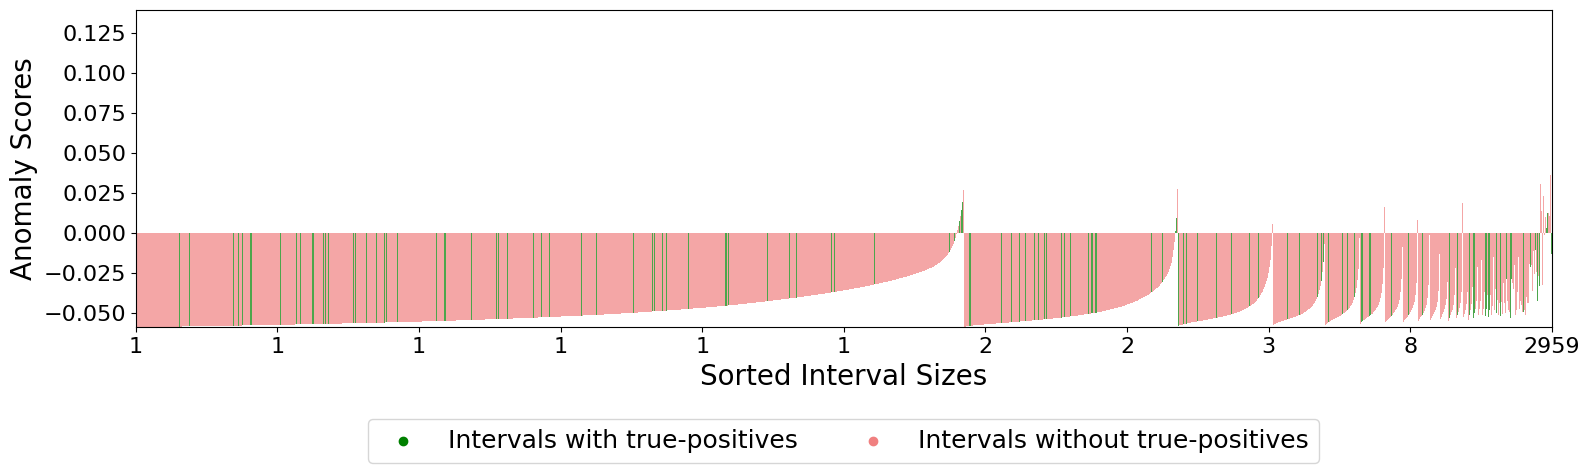

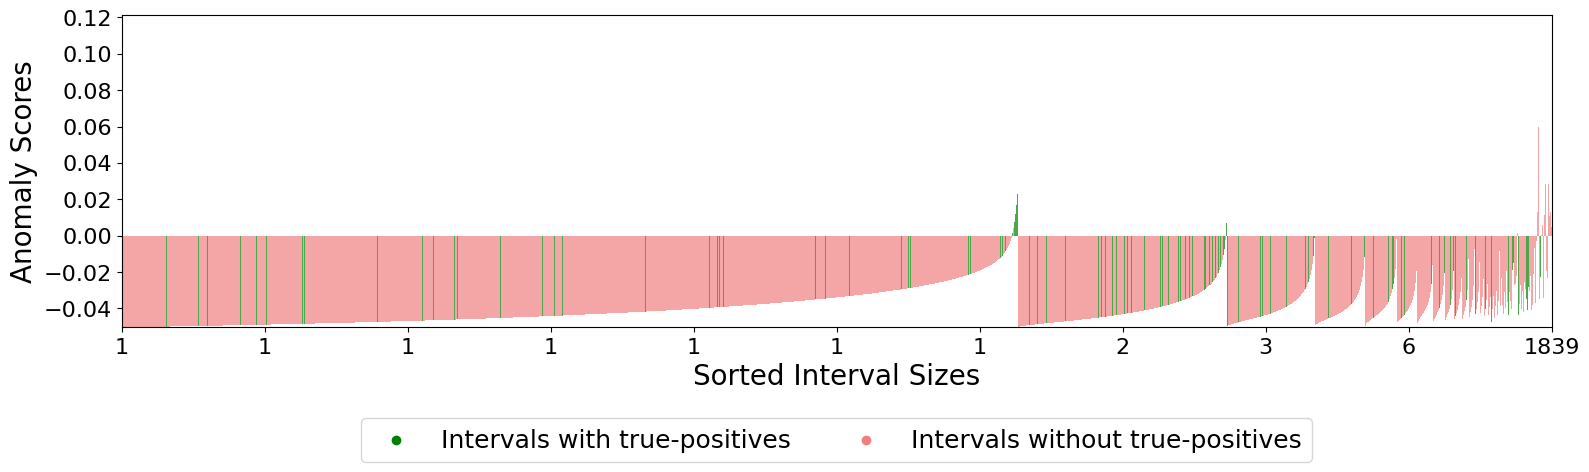

In [212]:

method = "Multi-Feature"

for i, iteration in enumerate(sorted(list(combined_results.keys()))):

        
    # Create lists
    successes = [1] * len(intervals_decisions[iteration]['Coverage Decisions']) + [0] * len(intervals_decisions[iteration]['No Coverage Decisions'])
    decisions = intervals_decisions[iteration]['Coverage Decisions'] + intervals_decisions[iteration]['No Coverage Decisions']
    sizes = intervals_sizes[iteration]['Intervals Sizes with TP'] + intervals_sizes[iteration]['Intervals Sizes without TP']

    # Sort first by size (ascending), then by decision (ascending)
    sorted_indices = np.lexsort((decisions, sizes))  # sizes first, then decisions

    sorted_decisions = np.array(decisions)[sorted_indices]
    sorted_sizes = np.array(sizes)[sorted_indices]
    sorted_successes = np.array(successes)[sorted_indices]

    # # create a subset
    # sorted_decisions = sorted_decisions[:100]
    # sorted_sizes = sorted_sizes[:100]
    # sorted_successes = sorted_successes[:100]


    # Define colors based on successes
    colors = ['green' if success == 1 else 'lightcoral' for success in sorted_successes]

    # Plot
    #plt.figure(figsize=(16, 5))
    fig, ax = plt.subplots(figsize=(16, 5))
    plt.bar(np.arange(len(sorted_sizes)), sorted_decisions, color=colors, alpha=0.7, width=1.0)

    # set meaningful x ticks, every 10% of the data, and show size
    xticks = np.linspace(0, len(sorted_sizes) - 1, 11)  # Avoid out-of-bounds index
    xticks = np.round(xticks).astype(int)  # Convert to valid indices
    xticklabels = [sorted_sizes[i] for i in xticks]  # Get corresponding values
    plt.xticks(xticks, xticklabels, fontsize=16)

    # increase font size for y-axis
    plt.yticks(fontsize=16)

    # set y limits based on the decision values
    plt.ylim(min(sorted_decisions), max(sorted_decisions))
    plt.xlim(-1, len(sorted_sizes))

    # create a legend using empty scatter plot
    plt.scatter([], [], color='green', label='Intervals with true-positives')
    plt.scatter([], [], color='lightcoral', label='Intervals without true-positives')
    # place legend flattened at the bottom
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize=18)



    plt.xlabel("Sorted Interval Sizes", fontsize=20)
    plt.ylabel("Anomaly Scores", fontsize=20)
    #plt.legend(loc='upper right', fontsize=16)
    #plt.title("Decisions as a Function of Sizes")
    plt.tight_layout()
    plt.savefig(figures_folder / f"decisions_sizes_v2_{iteration.lower().replace(' ', '_')}.png", dpi=300)
    plt.show()
    plt.close()


# Qualitative analysis

In [237]:
if data_type == "train":
    raise ValueError("Cannot calculate the coverage for the training data")

In [213]:
data_type = "test"
filename = "detections.pkl"
detections_file = save_folder / runs[0] / "1_split" / "evaluation" / data_type / "anomaly_detection" / filename
detections_file

PosixPath('/work3/s194262/GitHub/fault_management_uds/models/transformer/7_anomalous/iteration=0_250206_0903/1_split/evaluation/test/anomaly_detection/detections.pkl')

In [214]:
# load the detections file
with open(detections_file, 'rb') as f:
    detections = pickle.load(f)

In [215]:
detection_theme = "Overall Most Accurate" # ["Overall Most Accurate", "Overall Least Accurate"]
detection_type = "Top 1"

In [232]:
# Extract
detection = detections[detection_theme][detection_type]
starttime = detection['Start Time']
start_idx = detection['Start Index']
endtime = detection['End Time']
end_idx = detection['End Index']

# Get the data to visualize anomaly
go_back_forth = 2*(end_idx - start_idx)

show_start = starttime - pd.Timedelta(minutes=go_back_forth)
show_end = endtime + pd.Timedelta(minutes=go_back_forth)     


In [217]:
from fault_management_uds.detection_results import set_meaningful_xticks
from fault_management_uds.plots import visualize_error_span

In [225]:
# Find the index of the closest values
show_start_idx = (np.abs(starttimes - show_start)).argmin()
show_end_idx = (np.abs(starttimes - show_end)).argmin()
show_start_idx, show_end_idx

(3737271, 3737271)

In [221]:


for i, iteration in enumerate(sorted(list(combined_results.keys()))):



    starttimes = pd.date_range(start=show_start, end=show_end, freq='1min')
    starttimes = combined_results[iteration]["Starttimes"]


    # Identify start and end indices

    # Find the index of the closest values
    show_start_idx = (np.abs(starttimes - show_start)).argmin()
    show_end_idx = (np.abs(starttimes - show_end)).argmin()

    # get the new show start and end
    show_start = starttimes[show_start_idx]
    show_end = starttimes[show_end_idx]

    # show_start_idx = np.where(starttimes == show_start)[0][0]
    # show_end_idx = np.where(starttimes == show_end)[0][0]

    show_timestamps = pd.date_range(start=show_start, end=show_end, freq='1min')
    # create the indicator
    indicator = np.zeros(len(show_timestamps))
    mask = (show_timestamps >= starttime) & (show_timestamps <= endtime)
    indicator[mask] = 1


    # create an indicator for the detection algorithm, based on the decision values and threshold
    decision_values = combined_results[iteration]['Decision Function'][show_start_idx:show_end_idx+1]
    threshold = combined_results[iteration]["Optimal Threshold"]

    detection_indicator = np.zeros(len(decision_values))
    detection_indicator[decision_values > threshold] = 1
    indicator_dict = {
        'indicator': detection_indicator,
        'colormap': {
            0: 'none',
            1: 'firebrick',
        }
    }



    fig, axs = plt.subplots(1, 1, figsize=(10, 2))

    # # Inside your plotting function/loop
    # formatter = ticker.FormatStrFormatter('%.0f')  # Change to the desired format, e.g., '%.3f' for three decimal places

    # # Extract from the model outputs
    # start_idx = np.where(starttimes == show_start)[0][0]
    # end_idx = np.where(starttimes == show_end)[0][0]
    # data = outputs[start_idx:end_idx+1, :]


    axs = visualize_error_span(axs, indicator_dict, show_start, show_end, adjust='full-point')
    # Extract the decision values
    decision_values = combined_results[iteration]['Decision Function'][show_start_idx:show_end_idx+1]
    # Plot the decision function
    axs.plot(show_timestamps, decision_values, color='indianred', label='Score')
    # get the optimal threshold
    threshold = combined_results[iteration]["Optimal Threshold"]
    axs.axhline(threshold, color='grey', linestyle='--', label='Threshold', linewidth=1.2)


    # true start and stop
    axs.axvline(starttime, color='green', linestyle='--', linewidth=1.2, label='True Start')
    axs.axvline(endtime, color='red', linestyle='--', linewidth=1.2, label='True End')

    # formatting
    decision_values = np.insert(decision_values, 0, threshold) # add threshold as first element
    min_max_diff_div = (max(decision_values) - min(decision_values)) / 10
    axs.set_ylim(decision_values.min()-min_max_diff_div, decision_values.max()+min_max_diff_div)  # Ensure unique y-axis limits
    #axs[i, 1].set_yticks([0])
    #axs[i, 1].yaxis.set_major_formatter(formatter)
    axs.set_xlim(show_start, show_end)
    #axs.set_title('Anomaly Score', fontsize=14)
    #axs[i+1].set_ylabel('Values', fontsize=12, rotation=0, labelpad=10, ha='right', va='center')
    axs.legend(loc='upper right', fontsize=12)#, bbox_to_anchor=(1.25, 1))

    # set y label
    axs.set_ylabel('Anomaly Score', fontsize=12)

    # remove xticks
    axs = set_meaningful_xticks(axs, show_start, show_end)

    plt.tight_layout()
    plt.savefig(figures_folder / f"decision_time_series_{iteration.lower().replace(' ', '_')}.png", dpi=150)
    plt.show()
    plt.close()



/tmp/ipykernel_4043124/947068232.py:76: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs.set_xlim(show_start, show_end)
Locator attempting to generate 1460 ticks ([16918.0, ..., 18377.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 35040 ticks ([16917.166666666668, ..., 18377.125]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1460 ticks ([16918.0, ..., 18377.0]), which exceeds Locator.MAXTICKS (1000).


KeyboardInterrupt: 

Locator attempting to generate 1460 ticks ([16918.0, ..., 18377.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 35040 ticks ([16917.166666666668, ..., 18377.125]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1460 ticks ([16918.0, ..., 18377.0]), which exceeds Locator.MAXTICKS (1000).


Error in callback <function _draw_all_if_interactive at 0x7f3f97f23c10> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Locator attempting to generate 1460 ticks ([16918.0, ..., 18377.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 35040 ticks ([16917.166666666668, ..., 18377.125]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1460 ticks ([16918.0, ..., 18377.0]), which exceeds Locator.MAXTICKS (1000).


Error in callback <function flush_figures at 0x7f3e9e5aed30> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [222]:
show_start, show_end    

(Timestamp('2018-04-26 03:13:00'), Timestamp('2018-04-26 03:13:00'))

In [219]:
starttimes

DatetimeIndex(['2010-08-01 02:09:00', '2010-08-01 02:10:00',
               '2010-08-01 02:11:00', '2010-08-01 02:12:00',
               '2010-08-01 02:13:00', '2010-08-01 02:14:00',
               '2010-08-01 02:15:00', '2010-08-01 02:16:00',
               '2010-08-01 02:17:00', '2010-08-01 02:18:00',
               ...
               '2018-04-26 03:04:00', '2018-04-26 03:05:00',
               '2018-04-26 03:06:00', '2018-04-26 03:07:00',
               '2018-04-26 03:08:00', '2018-04-26 03:09:00',
               '2018-04-26 03:10:00', '2018-04-26 03:11:00',
               '2018-04-26 03:12:00', '2018-04-26 03:13:00'],
              dtype='datetime64[ns]', length=3737272, freq=None)

In [ ]:
raise ValueError("Stop here")

ValueError: Stop here

## Matrix of metrics

rows are iterations, columns are metrics

In [ ]:
results_dict = {}

for i, iteration in enumerate(sorted(list(combined_results.keys()))):
    results_dict[iteration] = {}
    # calculate all the metrics
    Predicted = combined_results[iteration]['Predicted']
    decision_function = combined_results[iteration]['Decision Function']
    actual = combined_results[iteration]["Actual"]

    # AUC
    fpr, tpr, _ = roc_curve(actual, decision_function)
    roc_auc = auc(fpr, tpr)
    results_dict[iteration]['AUC'] = roc_auc
    # Precision
    results_dict[iteration]['Precision'] = precision_score(actual, Predicted)
    # Recall
    results_dict[iteration]['Recall'] = recall_score(actual, Predicted)
    # TODO: timing
    indices_of_ones = [index for index, value in enumerate(actual) if value == 1]
    _, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)
    results_dict[iteration]['Timing'] = np.mean(get_timing(Predicted, anomaly_start_end))


results_df = pd.DataFrame(results_dict).T
# inverse the order of the iterations
results_df = results_df.iloc[::-1]

Stopping with 1 anomalies left
Stopping with 1 anomalies left


In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap that is completely white
custom_cmap = LinearSegmentedColormap.from_list("white_cmap", ["white", "white"], N=256)


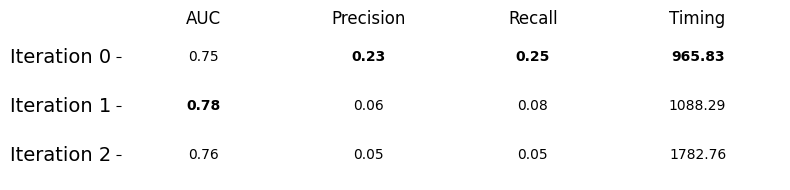

In [ ]:
visualize_metric_matrix('all_metrics', results_df, custom_cmap, 2, suffix=None, 
                        high_best=[True, True, True, False],
                        figsize=(8, 2), save_folder=figures_folder,
                        top_n_bold=0,
                        annotate_row_wise=False, 
                        ysize=14
)
visualize_metric_matrix('all_metrics', results_df, custom_cmap, 2, suffix=None, 
                        high_best=[True, True, True, False],
                        figsize=(8, 2), save_folder=None,
                        top_n_bold=0,
                        annotate_row_wise=False, 
                        ysize=14
)


## TODO:

- How do the other indicators work?